# Gym Exercise Recommendation

The idea of this project is to create a recommendation based algorithm built on top of a gym exercise dataset.
The goal for v1 release is to have a model that will recommend exercises based on user level (beginner, intermediate, advanced), type of exercise/training, equipment available and body part. -> model for this is created.
For the v2 release, I'd like to have some user information/profiles in a way that a content-based and collaborative filtering.
For the v3 release, I'm aiming to have a frontend webapp/mobile app users can interact with.
For the v4 release, the goal is to also include meal planning. Users will be suggested meals based on their weight, age, body-type and gym goal (getting more swollen, losing weight, etc).

To-do
- When user input is 'any' when questioned about the equipment, it is not assuming what 'any' means.
Expected behaviour: when user says 'any' then equipment isn't taken into consideration when calculating Cosine similarity. (this applies to other columns besides 'equipment'. How many of the inputs does the user have to answer to mandatory? 2/3? 1/3? 3/3?
- Transform notebook into script that can be ran/called by API (backend)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
# Reads CSV
data = pd.read_csv(r'/home/jmsbs/PycharmProjects/gym_exercise_recommendation/megaGymDataset.csv') 

In [14]:
data.rename(columns={'Unnamed: 0':'ID'}, inplace=True )
data = data.drop(columns=['Rating', 'RatingDesc'])

data

,ID,Title,Desc,Type,BodyPart,Equipment,Level
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate
1,1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,Strength,Abdominals,Bands,Intermediate
2,2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,Strength,Abdominals,Bands,Intermediate
3,3,Banded crunch,The banded crunch is an exercise targeting the...,Strength,Abdominals,Bands,Intermediate
4,4,Crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate
...,...,...,...,...,...,...,...
2913,2913,EZ-bar skullcrusher-,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate
2914,2914,Lying Close-Grip Barbell Triceps Press To Chin,NaN,Strength,Triceps,E-Z Curl Bar,Beginner
2915,2915,EZ-Bar Skullcrusher - Gethin Variation,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate
2916,2916,TBS Skullcrusher,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate


In [15]:
sqldf("SELECT * FROM data GROUP BY Type", globals())

,ID,Title,Desc,Type,BodyPart,Equipment,Level
0,149,Roc Everest,None,Cardio,Abdominals,Other,Intermediate
1,1217,Kneeling Jump Squat,None,Olympic Weightlifting,Glutes,Barbell,Beginner
2,96,Sledgehammer swing,The sledgehammer swing is an exercise working ...,Plyometrics,Abdominals,Other,Intermediate
3,917,Bench Press With Short Bands,None,Powerlifting,Chest,Bands,Beginner
4,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate
5,204,Stomach Vacuum,None,Stretching,Abdominals,Body Only,Beginner
6,1159,Forward Drag with Press,None,Strongman,Chest,Other,Beginner


In [16]:
le = LabelEncoder() # Create a LabelEncoder object

# Fit the LabelEncoder to the data and transform it
data['Type_encoded'] = le.fit_transform(data['Type'])
data['Equipment_encoded'] = le.fit_transform(data['Equipment'])
data['BodyPart_encoded'] = le.fit_transform(data['BodyPart'])

# One-hot encode the 'Level' column
data = pd.concat([data, pd.get_dummies(data['Level'], prefix='Level')], axis=1)

data

,ID,Title,Desc,Type,BodyPart,Equipment,Level,Type_encoded,Equipment_encoded,BodyPart_encoded,Level_Beginner,Level_Expert,Level_Intermediate
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate,4,0,0,False,False,True
1,1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,Strength,Abdominals,Bands,Intermediate,4,0,0,False,False,True
2,2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,Strength,Abdominals,Bands,Intermediate,4,0,0,False,False,True
3,3,Banded crunch,The banded crunch is an exercise targeting the...,Strength,Abdominals,Bands,Intermediate,4,0,0,False,False,True
4,4,Crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate,4,0,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,2913,EZ-bar skullcrusher-,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,4,5,16,False,False,True
2914,2914,Lying Close-Grip Barbell Triceps Press To Chin,NaN,Strength,Triceps,E-Z Curl Bar,Beginner,4,5,16,True,False,False
2915,2915,EZ-Bar Skullcrusher - Gethin Variation,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,4,5,16,False,False,True
2916,2916,TBS Skullcrusher,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,4,5,16,False,False,True


<Axes: >

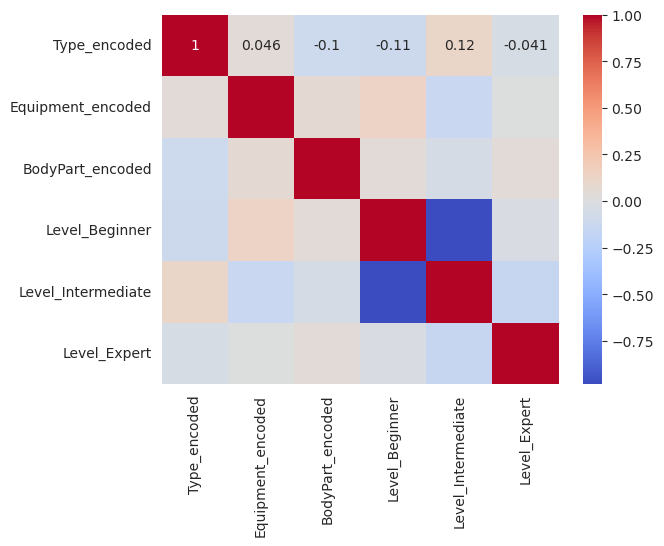

In [17]:
heatmap_columns = ['Type_encoded', 'Equipment_encoded', 'BodyPart_encoded', 'Level_Beginner', 'Level_Intermediate', 'Level_Expert']
sns.heatmap(data[heatmap_columns].corr(), annot=True, cmap='coolwarm')


In [18]:
# Compute Pearson correlation coefficient and p-value
columns_for_corr = ['Type_encoded', 'Equipment_encoded', 'BodyPart_encoded', 'Level_Beginner', 'Level_Intermediate', 'Level_Expert']
def calc_correlation():
    for i in range(len(columns_for_corr)):
        for j in range(i + 1, len(columns_for_corr)):
            correlation_coefficient, p_value = pearsonr(data[columns_for_corr[i]], data[columns_for_corr[j]])
            print(f"Pearson correlation coefficient for '{columns_for_corr[i]}' and '{columns_for_corr[j]}':", correlation_coefficient)
            print("P-value:", p_value)
calc_correlation()

Pearson correlation coefficient for 'Type_encoded' and 'Equipment_encoded': 0.0459001495141108
P-value: 0.013149204295333249
Pearson correlation coefficient for 'Type_encoded' and 'BodyPart_encoded': -0.10376530824440429
P-value: 1.93161380775923e-08
Pearson correlation coefficient for 'Type_encoded' and 'Level_Beginner': -0.10892851000294967
P-value: 3.6527750866173033e-09
Pearson correlation coefficient for 'Type_encoded' and 'Level_Intermediate': 0.11512365414422844
P-value: 4.463541862535067e-10
Pearson correlation coefficient for 'Type_encoded' and 'Level_Expert': -0.041029344676081415
P-value: 0.026669053553307776
Pearson correlation coefficient for 'Equipment_encoded' and 'BodyPart_encoded': 0.06489075217355009
P-value: 0.00045234309440306074
Pearson correlation coefficient for 'Equipment_encoded' and 'Level_Beginner': 0.13365264766046686
P-value: 4.1933796397477245e-13
Pearson correlation coefficient for 'Equipment_encoded' and 'Level_Intermediate': -0.13242511824905298
P-value

In [19]:
columns = ['Type_encoded', 'Equipment_encoded', 'BodyPart_encoded', 'Level_Beginner', 'Level_Intermediate', 'Level_Expert'] # Create a new DF
data1 = data[columns]

similarity_matrix = cosine_similarity(data1) # Calculate the Cosine Similarity between each pair of exercises

similarity_df = pd.DataFrame(similarity_matrix, index=data1.index, columns=data1.index) # Convert the similarity matrix to a DataFrame for better readability

similarity_df.index = data['ID'] # Replace the indices with the exercise titles

similarity_df.columns = data['ID'] # Replace the column names with the exercise titles


similarity_df

ID,0,1,2,3,4,5,6,7,8,9,...,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917
ID,,,,,,,,,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.971825,0.971825,...,0.247733,0.247733,0.102120,0.238845,0.238845,0.238845,0.224795,0.238845,0.238845,0.238845
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.971825,0.971825,...,0.247733,0.247733,0.102120,0.238845,0.238845,0.238845,0.224795,0.238845,0.238845,0.238845
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.971825,0.971825,...,0.247733,0.247733,0.102120,0.238845,0.238845,0.238845,0.224795,0.238845,0.238845,0.238845
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.971825,0.971825,...,0.247733,0.247733,0.102120,0.238845,0.238845,0.238845,0.224795,0.238845,0.238845,0.238845
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.971825,0.971825,...,0.247733,0.247733,0.102120,0.238845,0.238845,0.238845,0.224795,0.238845,0.238845,0.238845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,0.238845,0.238845,0.238845,0.238845,0.238845,0.238845,0.238845,0.238845,0.300385,0.300385,...,0.985005,0.985005,0.957344,1.000000,1.000000,1.000000,0.996644,1.000000,1.000000,1.000000
2914,0.224795,0.224795,0.224795,0.224795,0.224795,0.224795,0.224795,0.224795,0.286731,0.286731,...,0.981524,0.981524,0.960393,0.996644,0.996644,0.996644,1.000000,0.996644,0.996644,0.996644
2915,0.238845,0.238845,0.238845,0.238845,0.238845,0.238845,0.238845,0.238845,0.300385,0.300385,...,0.985005,0.985005,0.957344,1.000000,1.000000,1.000000,0.996644,1.000000,1.000000,1.000000


In [20]:
def recommend_exercises(ID, similarity_df, num_recommendations=5):
    exercise_similarities = similarity_df[ID]     # Get the column corresponding to the given exercise ID
    similar_exercises = exercise_similarities.sort_values(ascending=False)     # Sort the exercises in descending order of similarity
    top_exercises = similar_exercises.head(num_recommendations + 1)   # Get the top N exercises
    top_exercises = top_exercises.loc[top_exercises.index != ID]    # Remove the given exercise from the recommendations

    # Create a DataFrame with the exercise IDs and their corresponding titles
    top_exercises_df = pd.DataFrame(top_exercises)
    top_exercises_df['Title'] = top_exercises_df.index.map(data.set_index('ID')['Title'])
    top_exercises_df.reset_index(inplace=True)
    top_exercises_df.columns = ['ID', 'Similarity', 'Title']

    return top_exercises_df

# Test the function with a valid exercise ID from your DataFrame
valid_ID = data['ID'].iloc[0]  # Replace this with a valid ID from your DataFrame
recommendations = recommend_exercises(valid_ID, similarity_df)
print(recommendations)

   ID  Similarity                      Title
0   2         1.0      FYR Banded Plank Jack
1   3         1.0              Banded crunch
2   4         1.0                     Crunch
3   5         1.0  Decline band press sit-up
4   6         1.0      FYR2 Banded Frog Pump


In [21]:
sqldf("SELECT * FROM data WHERE Type = 'Strength' AND BodyPart = 'Chest' AND Equipment = 'Barbell'", globals())
# sqldf("SELECT * FROM data WHERE ID IN ('2', '3', '4', '5', '6')", globals())

,ID,Title,Desc,Type,BodyPart,Equipment,Level,Type_encoded,Equipment_encoded,BodyPart_encoded,Level_Beginner,Level_Expert,Level_Intermediate
0,927,Close-grip bench press,The close-grip bench press is a popular exerci...,Strength,Chest,Barbell,Intermediate,4,1,5,0,0,1
1,928,Barbell Bench Press - Medium Grip,The bench press is a compound exercise that bu...,Strength,Chest,Barbell,Intermediate,4,1,5,0,0,1
2,929,Decline barbell bench press,The decline barbell bench press is a popular u...,Strength,Chest,Barbell,Intermediate,4,1,5,0,0,1
3,930,Wide-grip bench press,The wide-grip bench press is a compound exerci...,Strength,Chest,Barbell,Beginner,4,1,5,1,0,0
4,931,Wide-Grip Decline Barbell Bench Press,None,Strength,Chest,Barbell,Beginner,4,1,5,1,0,0
5,932,Barbell Incline Bench Press Medium-Grip,The incline bench press is an upper body compo...,Strength,Chest,Barbell,Intermediate,4,1,5,0,0,1
6,933,Neck Press,None,Strength,Chest,Barbell,Beginner,4,1,5,1,0,0
7,934,Front Raise And Pullover,None,Strength,Chest,Barbell,Beginner,4,1,5,1,0,0
8,936,Barbell Bench Press-Wide Grip,The wide-grip bench pressis a compound exercis...,Strength,Chest,Barbell,Beginner,4,1,5,1,0,0
9,937,Wide-Grip Decline Barbell Pullover,None,Strength,Chest,Barbell,Beginner,4,1,5,1,0,0


In [22]:
user_inputs = []

def get_user_input(prompt):
    user_input = input(prompt)
    user_inputs.append(user_input)
    return user_input

def recommend_based_on_user_input(data, similarity_df, num_recommendations=5):
    # Fit the LabelEncoder to the data
    le_type = LabelEncoder().fit(data['Type'])
    le_body_part = LabelEncoder().fit(data['BodyPart'])
    le_equipment = LabelEncoder().fit(data['Equipment'])

    # Ask the user for their preferences
    type_preference = get_user_input("What type of exercise would you like to do?")
    body_part_preference = get_user_input("What body part would you like to train?")
    equipment_preference = get_user_input("What equipment do you have available?")
    
    # Encode the user's preferences using the fitted LabelEncoders
    type_encoded = le_type.transform([type_preference])
    body_part_encoded = le_body_part.transform([body_part_preference])
    equipment_encoded = le_equipment.transform([equipment_preference])

    # Create a DataFrame that contains the user's preferences
    user_preferences = pd.DataFrame({
        'Type_encoded': type_encoded,
        'BodyPart_encoded': body_part_encoded,
        'Equipment_encoded': equipment_encoded
    }, index=[0])

    # Filter the data to only include exercises that match the user's body part preference
    data_filtered = data[data['BodyPart_encoded'] == body_part_encoded[0]].copy()
     
    # If the user inputs 'any' for the equipment, do not filter the data based on equipment
    # if equipment_preference.lower() != 'any':
    #     data_filtered = data_filtered[data_filtered['Equipment_encoded'] == equipment_encoded[0]]

    # Compute the cosine similarity between the user's preferences and the filtered data
    similarity_scores = cosine_similarity(data_filtered[user_preferences.columns], user_preferences)

    # Sort the exercises by their similarity to the user's preferences
    data_filtered['Similarity'] = similarity_scores
    recommendations = data_filtered.sort_values(by='Similarity', ascending=False).head(num_recommendations)

    # Return the recommended exercises
    return recommendations[['ID', 'Title', 'Similarity', 'Level']]

recommendations = recommend_based_on_user_input(data, similarity_df)
print(f"User inputs were: {user_inputs}.")
print(f"The recommended exercises are the following: \n {recommendations}.")

ValueError: y contains previously unseen labels: 'aasdjkl;nasdj;kl'

In [ ]:
sqldf("SELECT * FROM data WHERE ID IN ('97', '10', '17', '16', '15')", globals())

In [ ]:
Strength = strength
